## Probability Calibration using ML-Insights 
### On Example of Mortality Model Using MIMIC ICU Data*

This workbook is intended to demonstrate why probability calibration may be useful, and how to do it using the ML-Insights package.  This is an abridged version of a longer workbook (which goes into more detail).

We build a random forest classifier to predict mortality.  We show that the uncalibrated model performs much worse than the calibrated version on log-loss (and brier score).

We demonstrate the "isotonic" and "sigmoid" calibration functions of sklearn and show the they are not as effective.

Finally, we show that even methods like boosting, which we might expect to be well-calibrated, benefit significantly from the calibration capabilities provided by ML-Insights.

*MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016).
https://mimic.physionet.org


In [1]:
# "pip install ml_insights" in terminal if needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ml_insights as mli
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from sklearn import clone
from sklearn.calibration import CalibratedClassifierCV



In the next few cells, we load in some data, inspect it, select columns for our features and outcome (mortality) and fill in missing values with the median of that column.

In [2]:
# Load dataset derived from the MMIC database

lab_aug_df = pd.read_csv("data/lab_vital_icu_table.csv")

In [3]:
lab_aug_df.head(10)

,subject_id,hadm_id,icustay_id,aniongap_min,aniongap_max,albumin_min,albumin_max,bicarbonate_min,bicarbonate_max,bilirubin_min,...,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean
0,9,150750,220597,13.0,13.0,NaN,NaN,26.0,30.0,0.4,...,98.850000,14.0,19.0,14.369565,35.500001,37.888887,37.049383,95.0,100.0,97.650000
1,13,143045,263738,10.0,14.0,3.9,3.9,23.0,24.0,0.4,...,93.772727,11.0,25.0,15.320000,35.944443,37.400002,36.653534,94.0,100.0,97.700000
2,20,157681,264490,12.0,12.0,NaN,NaN,21.0,21.0,NaN,...,75.058333,10.0,27.0,15.404762,35.900002,37.299999,36.545714,95.0,100.0,98.435897
3,28,162569,225559,13.0,13.0,NaN,NaN,23.0,23.0,NaN,...,69.133333,9.0,32.0,16.677419,35.900002,37.700001,37.033333,92.0,100.0,96.419355
4,37,188670,213503,9.0,10.0,NaN,NaN,33.0,35.0,NaN,...,73.297610,15.0,30.0,22.241379,36.833335,38.055556,37.333334,89.0,99.0,96.533333
5,71,111944,211832,13.0,30.0,3.6,4.7,17.0,26.0,0.4,...,79.222208,13.0,25.0,17.130435,35.722224,37.833332,37.351852,99.0,100.0,99.862069
6,72,156857,239612,18.0,18.0,NaN,NaN,20.0,20.0,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,78,100536,233150,9.0,9.0,2.7,3.1,26.0,26.0,0.8,...,121.129705,11.0,24.0,16.764706,36.333334,36.833335,36.577778,96.0,100.0,98.470588
8,88,123010,297289,13.0,18.0,NaN,NaN,19.0,26.0,NaN,...,91.884615,9.0,45.0,20.352941,35.722224,39.111112,37.810185,99.0,100.0,99.962963
9,95,160891,216431,13.0,17.0,NaN,NaN,23.0,26.0,NaN,...,93.952386,14.0,20.0,16.363636,35.722224,36.666667,36.305556,96.0,100.0,98.071429


In [4]:
X = lab_aug_df.loc[:,['aniongap_min', 'aniongap_max',
       'albumin_min', 'albumin_max', 'bicarbonate_min', 'bicarbonate_max',
       'bilirubin_min', 'bilirubin_max', 'creatinine_min', 'creatinine_max',
       'chloride_min', 'chloride_max', 
       'hematocrit_min', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max',
       'lactate_min', 'lactate_max', 'platelet_min', 'platelet_max',
       'potassium_min', 'potassium_max', 'ptt_min', 'ptt_max', 'inr_min',
       'inr_max', 'pt_min', 'pt_max', 'sodium_min', 'sodium_max', 'bun_min',
       'bun_max', 'wbc_min', 'wbc_max','sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean',
       'meanbp_min', 'meanbp_max', 'meanbp_mean', 'resprate_min',
       'resprate_max', 'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean',
       'spo2_min', 'spo2_max', 'spo2_mean']]
y = lab_aug_df['hospital_expire_flag']

In [5]:
# Impute the median for in each column to replace NA's 

median_vec = [X.iloc[:,i].median() for i in range(len(X.columns))]

for i in range(len(X.columns)):
    X.iloc[:,i].fillna(median_vec[i],inplace=True)

Now we divide the data into training, and test sets via a 70/30 split.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=942)

Next, we fit a Random Forest model to our training data using the SplineCalibratedClassifierCV function in ML-Insights.  The resulting object is a model containing the usual "predict" and "predict_proba" methods.  It also contains the uncalibrated classifier and the calibration function that "corrects" the output to give more accurate probabilities.  This enables us to see exactly why and how the calibration helps us perform better on metrics such as log-loss and brier score.  

Note that the percentage of trees that voted "yes" in a random forest are better understood as mere scores.  A higher value should generally indicate a higher probability of mortality.  However, there is no reason to expect these to be well-calibrated probabilities.  The fact that, say, 60% of the trees voted "yes" on a particular case does not mean that that case has a 60% probability of mortality.

We will demonstrate this empirically later.

In [7]:
rfm = RandomForestClassifier(n_estimators = 500, class_weight='balanced_subsample', random_state=942, n_jobs=-1 )
rfm_calib = mli.SplineCalibratedClassifierCV(rfm)
rfm_calib.fit(X_train,y_train)

training fold 1 of 5
training fold 2 of 5
training fold 3 of 5
training fold 4 of 5
training fold 5 of 5
Training Full Model
Determining Calibration Function
Originally there were 958 knots.  Reducing to 200 while preserving first and last knot.
Trying 43 values of C between 0.0001 and 10000000000.0
Best value found C = [  4.64158883e+09]


SplineCalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=942, verbose=0, warm_start=False),
               cv=5, method='logistic')

In [8]:
test_res_uncalib = rfm_calib.uncalibrated_classifier.predict_proba(X_test)[:,1]
test_res_calib = rfm_calib.predict_proba(X_test)[:,1]


As you can see below, there is a significant improvement after calibration. (Lower loss is better)

In [9]:
log_loss(y_test,test_res_uncalib)

0.254672254282787

In [10]:
log_loss(y_test,test_res_calib)

0.24558429664906684

The following shows that the predict_proba method of rfm_calib is the same as using the uncalibrated classifier and then applying the calibration function.

In [11]:
test_res_calib_2 = rfm_calib.calib_func(test_res_uncalib)
log_loss(y_test,test_res_calib_2)

0.24558429664906684

The default logistic option is intended to reduce the log-loss (aka deviance).  But we see here that it improves the Brier Score as well.

In [12]:
brier_score_loss(y_test,test_res_uncalib)

0.074039569117289192

In [13]:
brier_score_loss(y_test,test_res_calib)

0.072411379426813027

This next plot shows the calibration function that was estimated.  If the original model had been perfectly calibrated, we would expect the calibration function to be y=x.  Instead, the plot shows that the Random Forest scores overestimate the probability between 0 and 0.1 and underestimate it after that.

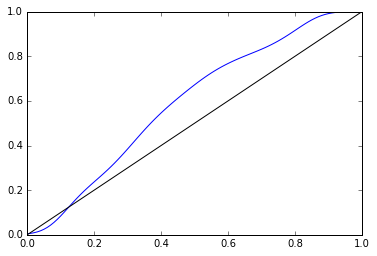

In [14]:
plt.plot(np.linspace(0,1,101),rfm_calib.calib_func(np.linspace(0,1,101)))
plt.plot(np.linspace(0,1,101),np.linspace(0,1,101),'k')

Using histograms and bin counts, we can look at estimated empirical probabilities on the test set to see how well our calibration is working.

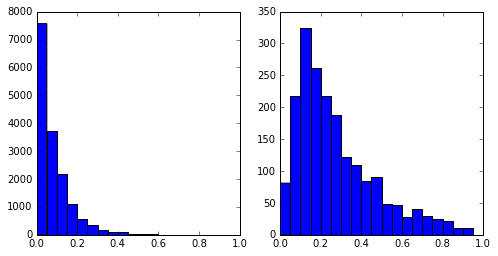

In [15]:
# Side by side histograms showing scores of positive vs negative cases

fig, axis = plt.subplots(1,2, figsize = (8,4))

ax=axis.flatten()
countvec0_test = ax[0].hist(test_res_uncalib[np.where(y_test==0)],bins=20,range=[0,1]);
countvec1_test = ax[1].hist(test_res_uncalib[np.where(y_test==1)],bins=20,range=[0,1]);

In [16]:
emp_prob_vec_test = countvec1_test[0]/(countvec0_test[0]+countvec1_test[0])



/Applications/anaconda/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


The below plot shows how well the calibrated probabilities fit the empirical (binned) probabilities on an independent test set.

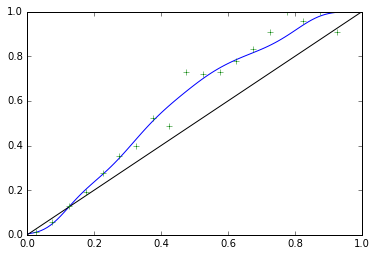

In [17]:
plt.plot(np.linspace(0,1,101),rfm_calib.calib_func(np.linspace(0,1,101)))
plt.plot(np.linspace(0,1,101),np.linspace(0,1,101),'k')
plt.plot(np.linspace(.025,.975,20), emp_prob_vec_test, 'g+')

## Existing Sklearn Calibration Functionality

Note, sklearn has a `CalibratedClassifierCV` function, but it does not seem to work as well.

In [18]:
clf_isotonic_xval = CalibratedClassifierCV(rfm, method='isotonic', cv=5)
clf_isotonic_xval.fit(X_train,y_train)
prob_pos_isotonic_xval = clf_isotonic_xval.predict_proba(X_test)[:, 1]

In [19]:
log_loss(y_test,prob_pos_isotonic_xval), log_loss(y_test,test_res_calib)

(0.24892041795293879, 0.24558429664906684)

In [20]:
brier_score_loss(y_test,prob_pos_isotonic_xval), brier_score_loss(y_test,test_res_calib)

(0.072655372713224517, 0.072411379426813027)

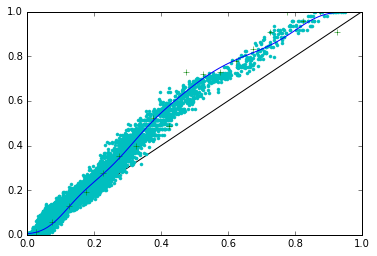

In [21]:
plt.plot(np.linspace(0,1,101),np.linspace(0,1,101),'k')
plt.plot(test_res_uncalib,prob_pos_isotonic_xval,'c.')
plt.plot(np.linspace(.025,.975,20),emp_prob_vec_test,'g+')
plt.plot(np.linspace(0,1,101),rfm_calib.calib_func(np.linspace(0,1,101)),'b')



The CalibratedClassifierCV in sklearn averages the results of mutiple calibrated models, resulting in significant variance which hampers its performance.  By contrast, ML-Insights refits the full model, and computes one calibration on the entire cross-validated answer set.

For this reason, the log-loss is significantly worse (and brier score is worse as well) using the isotonic variant (though both are improved from the uncalibrated version)

In [22]:
clf_sigmoid_xval = CalibratedClassifierCV(rfm, method='sigmoid', cv=5)
clf_sigmoid_xval.fit(X_train,y_train)
prob_pos_sigmoid_xval = clf_sigmoid_xval.predict_proba(X_test)[:, 1]

In [23]:
log_loss(y_test,prob_pos_sigmoid_xval), log_loss(y_test,test_res_calib)

(0.25435730616775026, 0.24558429664906684)

In [24]:
brier_score_loss(y_test,prob_pos_sigmoid_xval), brier_score_loss(y_test,test_res_calib)

(0.073790672155675974, 0.072411379426813027)

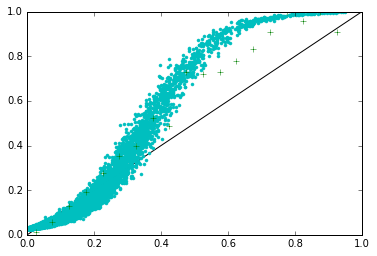

In [25]:
plt.plot(np.linspace(0,1,101),np.linspace(0,1,101),'k')
plt.plot(test_res_uncalib,prob_pos_sigmoid_xval,'c.')
plt.plot(np.linspace(.025,.975,20),emp_prob_vec_test,'g+')



The sigmoid variant assumes a strict parametric form for the calibration, which is not accurate in many cases, therefore, its performance is not very good.

### Calibrating with Boosting Models
It is perhaps unsurprising that random forest vote percentages would need calibration since they are not intended to estimate the true probabilities.  However, as we see below, even methods like boosting perform better if calibration is applied. (Warning: next cell may take 30+ minutes to run).  For a quicker demonstration, decrease the max_depth and/or the n_estimators)

In [26]:
gbm = GradientBoostingClassifier(n_estimators = 1000, max_depth=7, learning_rate=.02, random_state=942)
gbm_calib = mli.SplineCalibratedClassifierCV(gbm)
gbm_calib.fit(X_train,y_train)

training fold 1 of 5
training fold 2 of 5
training fold 3 of 5
training fold 4 of 5
training fold 5 of 5
Training Full Model
Determining Calibration Function
Originally there were 39074 knots.  Reducing to 200 while preserving first and last knot.
Trying 43 values of C between 0.0001 and 10000000000.0
Best value found C = [  1.00000000e+10]


SplineCalibratedClassifierCV(base_estimator=GradientBoostingClassifier(init=None, learning_rate=0.02, loss='deviance',
              max_depth=7, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=942, subsample=1.0, verbose=0,
              warm_start=False),
               cv=5, method='logistic')

In [30]:
test_res_uncalib_gbm = gbm_calib.uncalibrated_classifier.predict_proba(X_test)[:,1]
test_res_calib_gbm = gbm_calib.predict_proba(X_test)[:,1]

In [31]:
log_loss(y_test,test_res_uncalib_gbm)

0.24276942644611732

In [32]:
log_loss(y_test,test_res_calib_gbm)

0.24063748922274583

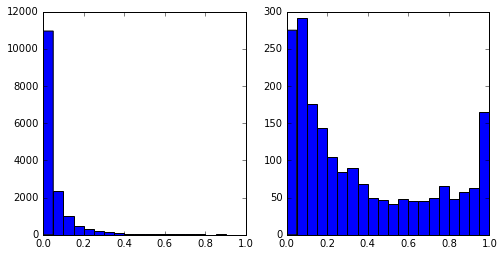

In [33]:
# Side by side histograms showing scores of positive vs negative cases

fig, axis = plt.subplots(1,2, figsize = (8,4))

ax=axis.flatten()
countvec0_test_gbm = ax[0].hist(test_res_uncalib_gbm[np.where(y_test==0)],bins=20,range=[0,1]);
countvec1_test_gbm = ax[1].hist(test_res_uncalib_gbm[np.where(y_test==1)],bins=20,range=[0,1]);

In [34]:
emp_prob_vec_test_gbm = countvec1_test_gbm[0]/(countvec0_test_gbm[0]+countvec1_test_gbm[0])



It is interesting to see that the boosting model has a very different calibration function.

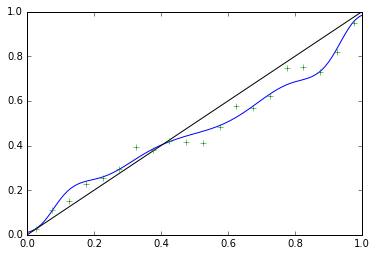

In [35]:
plt.plot(np.linspace(0,1,101),gbm_calib.calib_func(np.linspace(0,1,101)))
plt.plot(np.linspace(0,1,101),np.linspace(0,1,101),'k')
plt.plot(np.linspace(.025,.975,20), emp_prob_vec_test_gbm, 'g+')